# Part 1: load and prepare data

In [9]:
# Include Libraries
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

from pathlib import Path
import os
import shutil
import random

from PIL import Image
import numpy as np

from tqdm import tqdm
import pandas as pd

In [10]:
# # Turn folders into Train and Test sets
# for dirpath, dirnames, filenames in os.walk("data/asl_dataset"):
#   for filename in (filenames):

#     # generate random number between 1 and 10
#     rand_int = random.randint(1, 10)

#     # use rand_int to determine whether image goes to test or train

#     if rand_int >= 9:
#       split_path = Path("data/test")
#     else:
#       split_path = Path("data/train")

#     # split the full path so we can pull the class folder name later
#     sub_paths = dirpath.split("/")

#     # generate souce path and destination path
#     src_path = Path(dirpath) / filename
#     dest_path = Path(split_path) / Path(sub_paths[len(sub_paths) - 1]) / filename

#     # Copy image to location, or create destination then copy
#     try:
#       shutil.copyfile(src_path, dest_path)
#     except IOError as io_err:
#       os.makedirs(os.path.dirname(dest_path))
#       shutil.copyfile(src_path, dest_path)

In [11]:
# # check for proper test/train split (aproxamatly 20 %)
# for dirpath, dirnames, filenames in os.walk(Path("data/asl_dataset")):
#     print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

# print("\n")

# for dirpath, dirnames, filenames in os.walk(Path("data/test")):
#     print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

# print("\n")

# for dirpath, dirnames, filenames in os.walk(Path("data/train")):
#     print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [12]:
# print((Image.open("data/train/0/hand1_0_bot_seg_1_cropped.jpeg")).size)

In [14]:
# pull images from sign language MNIST dataset
# train_df = pd.read_csv("data/sign_mnist_train.csv", header=0)
# test_df = pd.read_csv("data/sign_mnist_test.csv", header=0)

# getImagesFromDataFrame(train_df, 'train')
# getImagesFromDataFrame(test_df, 'test')

In [15]:
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import cv2
import torch

# Define a custom transform to perform edge detection
class EdgeDetection(object):
    def __init__(self):
        pass

    def __call__(self, image):
        # Convert the PIL image to a NumPy array
        image = np.array(image)

        # Convert to grayscale if the image is in color
        if len(image.shape) == 3 and image.shape[2] == 3:
            image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        # Apply Canny edge detection
        edges = cv2.Canny(image, threshold1=30, threshold2=100)

        # Convert the edge image back to a PIL image
        edge_image = Image.fromarray(edges)

        return edge_image
    
class RandomizeColorsOnBlackPixels(object):
    def __call__(self, tensor):
        # Identify black pixels
        black_pixels = (tensor[0] == 0) & (tensor[1] == 0) & (tensor[2] == 0)

        # Generate random colors for each channel for black pixels
        tensor[0][black_pixels] = torch.rand_like(tensor[0][black_pixels])
        tensor[1][black_pixels] = torch.rand_like(tensor[1][black_pixels])
        tensor[2][black_pixels] = torch.rand_like(tensor[2][black_pixels])

        return tensor
    
train_transform = transforms.Compose([
    transforms.Resize(size=(28, 28)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize(size=(28, 28)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])


In [16]:
# set up the directories to the images
train_dir = "data/train"
test_dir = "data/test"

# pull the images into datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=train_transform,  # a transform for the data
                                  target_transform=None) # a transform for the label/target

test_data = datasets.ImageFolder(root=test_dir,
                                  transform=test_transform,  # a transform for the data
                                  target_transform=None) # a transform for the label/target

train_data, test_data  

(Dataset ImageFolder
     Number of datapoints: 27455
     Root location: data/train
     StandardTransform
 Transform: Compose(
                Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=warn)
                Grayscale(num_output_channels=1)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 7172
     Root location: data/test
     StandardTransform
 Transform: Compose(
                Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=warn)
                Grayscale(num_output_channels=1)
                ToTensor()
            ))

In [17]:
# set up dataloader
BATCH_SIZE = 8
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=0,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              num_workers=0,
                              shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x173401c10>,
 <torch.utils.data.dataloader.DataLoader at 0x28a395410>)

In [18]:
class Net(nn.Module):
  def __init__(self, outputs) -> None:
    super().__init__()
    conv1 = 16
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=3,
                  out_channels=conv1,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=conv1,
                  out_channels=conv1,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                      stride=2)
    )
    self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=conv1,
                      out_channels=conv1,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=conv1,
                      out_channels=conv1,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                        stride=2)
        )
    self.classifier_layer = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=self.calculate_fc_input_size(),
                  out_features=outputs)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    #print(x.shape)
    x = self.conv_block_2(x)
    #print(x.shape)
    x = self.classifier_layer(x)
    #print(x.shape)
    return x
    
  def num_flat_features(self, x):
      size = x.size()[1:]  # all dimensions except the batch dimension
      num_features = 1
      for s in size:
          num_features *= s
      return num_features
  def calculate_fc_input_size(self):
      # Compute the input size for the fully connected layer
      dummy_input = torch.randn(1, 3, 128, 128)  #input size of 64 x 64
      x = self.conv_block_2(self.conv_block_1(dummy_input))
      return x.view(x.size(0), -1).size(1)

In [19]:
def train( model, epochs, dataloader ): # One epoch uses the entire training set (one batch at a time) - 60,000 images in this case
    
    criterion = nn.CrossEntropyLoss() 
    optimizer = optim.Adam( model.parameters(), lr= 1e-4 ) 
    trainloader = dataloader

    for epoch in range( epochs ): # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate( trainloader, 0 ):
            # get the inputs; data is a list of [inputs, labels]

            inputs, labels = data
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs) #predict the output with some training data
            loss = criterion(outputs, labels) #see how well we did

            loss.backward() #see how to change the weights to do better
            optimizer.step() #and actually change the weights

            # print statistics
            running_loss += loss.item()
            if i % 1000 == 999:    
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0

    print('Finished Training')

In [20]:
net = Net(36)

In [69]:
train(net, 1, train_dataloader)

[1,  1000] loss: 0.072
[1,  2000] loss: 0.088
[1,  3000] loss: 0.012
Finished Training


In [70]:
def evaluate( model, dataloader ):  

    testloader = dataloader
    correct = 0
    total = 0

    with torch.no_grad(): 
        for data in testloader:
            images, labels = data
            outputs = model( images )
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Just do a coarse evaluation... how many did we predict correcly?
    print( 'Accuracy of the network on the test images: %f %%' % ( 100 * correct / total) )

In [71]:
evaluate(net, test_dataloader)

Accuracy of the network on the test images: 87.367540 %


In [72]:
torch.save(net.state_dict(), "model")

In [88]:

image = Image.open("image.png")
label = 5
image = test_transform(image)
image = image.unsqueeze(0)
outputs = net( image )


# test_data_location = 701
# image, label = test_data[test_data_location]
# image = image.unsqueeze(0)
# outputs = net( image )

_, predicted = torch.max(outputs.data, 1)
print(test_data.classes)
print(outputs.data)

print(test_data.classes[predicted])



['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y']
tensor([[ -64.6775,   -1.6465,  -30.7249,  -45.6755,  -16.6800,  -22.2273,
          -41.9897,  -61.4280,  -49.0884,  -49.3089,  -84.1036,  -48.4775,
          -28.4454,  -10.8825,  -66.6475,  -42.9844,  -75.2255,  -38.8301,
          -28.9095,  -43.7351,  -87.0008,  -45.9911,  -51.6828,  -75.2535,
         -101.6493, -111.2796, -124.1686,  -87.1765,  -91.2014,  -94.8481,
         -112.7961, -102.7833, -101.5266, -101.9829,  -98.0648,  -99.2170]])
b


Image shape: torch.Size([1, 1, 28, 28])
torch.Size([28])


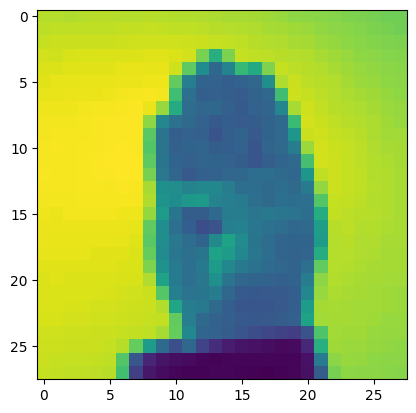

In [89]:
import matplotlib.pyplot as plt
print(f"Image shape: {image.shape}")
print(image.squeeze()[0].shape)
plt.imshow(image.squeeze())
plt.show()

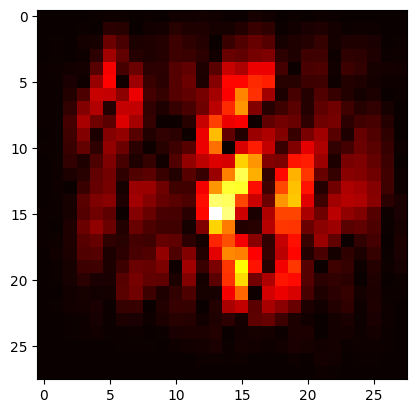

In [90]:
net.eval()

y = [5]
y = torch.LongTensor(y)
X = image

X.requires_grad_()

scores = net(X)
loss = torch.nn.functional.cross_entropy(scores, y)
loss.backward()
saliency, _ = torch.max(torch.abs(X.grad), dim=1)
saliency = saliency.numpy()
plt.imshow(saliency[0], cmap=plt.cm.hot)
X = X.detach()

